# Download Training data

In [1]:
import requests, zipfile, io
import pandas as pd

url = 'https://www.kaggle.com/api/v1/datasets/download/prishasawhney/mushroom-dataset?datasetVersionNumber=1'
r = requests.get(url)

with zipfile.ZipFile(io.BytesIO(r.content)) as z:
    with z.open('mushroom_cleaned.csv') as f:
        df = pd.read_csv(f)

In [2]:
df.head()

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,class
0,1372,2,2,10,3.807467,1545,11,1.804273,1
1,1461,2,2,10,3.807467,1557,11,1.804273,1
2,1371,2,2,10,3.612496,1566,11,1.804273,1
3,1261,6,2,10,3.787572,1566,11,1.804273,1
4,1305,6,2,10,3.711971,1464,11,0.943195,1


In [3]:
import s3fs

s3 = s3fs.S3FileSystem()
s3.mkdir("traindata")

FileExistsError: 

In [4]:
df.to_parquet('s3://traindata/train_raw.parquet', storage_options={"anon": False})

# Trainingsdaten aus Object Store lesen

In [5]:
import pandas as pd
df = pd.read_parquet('s3://traindata/train_raw.parquet', storage_options={"anon": False})

# Exploratory Data Analysis

In [6]:
df.head()

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,class
0,1372,2,2,10,3.807467,1545,11,1.804273,1
1,1461,2,2,10,3.807467,1557,11,1.804273,1
2,1371,2,2,10,3.612496,1566,11,1.804273,1
3,1261,6,2,10,3.787572,1566,11,1.804273,1
4,1305,6,2,10,3.711971,1464,11,0.943195,1


In [7]:
df.shape

(54035, 9)

In [8]:
df.dtypes

cap-diameter         int64
cap-shape            int64
gill-attachment      int64
gill-color           int64
stem-height        float64
stem-width           int64
stem-color           int64
season             float64
class                int64
dtype: object

In [9]:
df.nunique()

cap-diameter       1847
cap-shape             7
gill-attachment       7
gill-color           12
stem-height        1455
stem-width         3510
stem-color           13
season                4
class                 2
dtype: int64

In [10]:
df.isna().any().any()

False

In [11]:
df['class'].value_counts()

class
1    29675
0    24360
Name: count, dtype: int64

# Feature Engineering

In [12]:
categoricals = ['cap-shape', 'gill-attachment', 'gill-color', 'stem-color']
numericals = [c for c in df.drop('class', axis='columns').columns if c not in categoricals]
categoricals, numericals

(['cap-shape', 'gill-attachment', 'gill-color', 'stem-color'],
 ['cap-diameter', 'stem-height', 'stem-width', 'season'])

In [13]:
# this trips mlflow when loading model and predicing. omit for now, analyze later
if False:
    for category in categoricals:
        df[category] = df[category].astype('category')
    df.dtypes

# Final Test Set vorbereiten

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('class', axis='columns'), df['class'], random_state=42)

# Ein einfaches Model

In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

preprocessor = ColumnTransformer(
    [
        ("numerical", StandardScaler(), numericals),
        ("categorical", OneHotEncoder(sparse_output=False), categoricals),
    ],
)

clf = KNeighborsClassifier(n_neighbors=3)

pipeline = make_pipeline(preprocessor, clf)

# Modell evaluieren

In [16]:
from sklearn.model_selection import cross_val_score
n_folds = 10
scores = cross_val_score(pipeline, X_train, y_train, cv=n_folds)
f"{pipeline.steps[-1][-1]} has an accuracy of {scores.mean():0.2f} " \
f"(standard deviation {scores.std():0.2f}) over all {n_folds} folds"

'KNeighborsClassifier(n_neighbors=3) has an accuracy of 0.99 (standard deviation 0.00) over all 10 folds'

# Finale Score prüfen

KNeighborsClassifier(n_neighbors=3) has an accuracy of 0.99


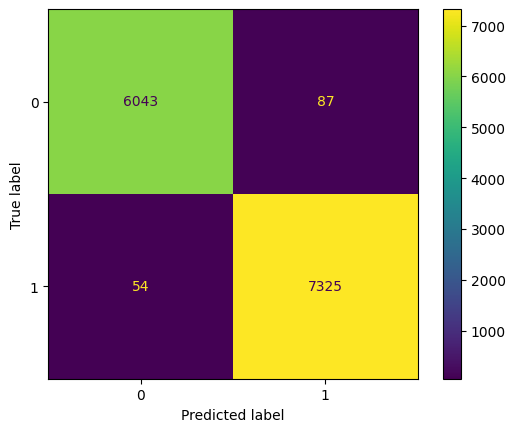

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test)

print(f"{pipeline.steps[-1][-1]} has an accuracy of {accuracy_score(y_test, y_pred):0.2f}")
plt.show()

# Alterative model without preprocessing

In [18]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=3)

In [19]:
scores = cross_val_score(clf, X_train, y_train, cv=10)

In [20]:
print(f"{clf} has an accuracy of {scores.mean():0.2f} (standard deviation {scores.std():0.2f})")

GradientBoostingClassifier(learning_rate=1.0) has an accuracy of 0.97 (standard deviation 0.01)


# Modell mit allen Daten trainieren

In [21]:
# XXX analyse watning about integer columns and missing values
import mlflow

mlflow.set_experiment('pipeline')
mlflow.sklearn.autolog()
pipeline.fit(df.drop('class', axis='columns'), df['class'])

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 327, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 421, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1367, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1360, in _read_helper
    result = read_yaml(root, file_name)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.1

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  ['cap-diameter',
                                                   'stem-height', 'stem-width',
                                                   'season']),
                                                 ('categorical',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['cap-shape',
                                                   'gill-attachment',
                                                   'gill-color',
                                                   'stem-color'])])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=3))])

In [26]:
import mlflow
logged_model = 'mlruns/713863224137089082/4374a31e0a364870967ea50d22b43360/artifacts/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
import pandas as pd
loaded_model.predict(df.drop('class', axis='columns'))

array([1, 1, 1, ..., 1, 1, 1])

In [27]:
from mlflow import MlflowClient

client = MlflowClient()
all_experiments = client.search_experiments()

print(all_experiments)


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 327, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 421, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1367, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1360, in _read_helper
    result = read_yaml(root, file_name)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.1

[<Experiment: artifact_location='file:///notebooks/mlruns/713863224137089082', creation_time=1726235742436, experiment_id='713863224137089082', last_update_time=1726235742436, lifecycle_stage='active', name='pipeline', tags={}>]
